In [55]:
from utils import *

In [56]:
points_msg=rospy.wait_for_message("/hsrb/head_rgbd_sensor/depth_registered/rectified_points",PointCloud2,timeout=5)
points_data = ros_numpy.numpify(points_msg)    
image_data = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]   
image=cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)
image = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]
    #hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV_FULL)
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print (image.shape)

(480, 640, 3)


In [57]:
_,corrected=correct_points(points_msg)


############head [ 9.85189973 -1.44166295  1.10333055] [ 0.9023354  -0.01331163  0.00635508 -0.43078212]


In [58]:
import matplotlib.pyplot as plt
%matplotlib inline


In [59]:
corrected['z'].shape

(480, 640)

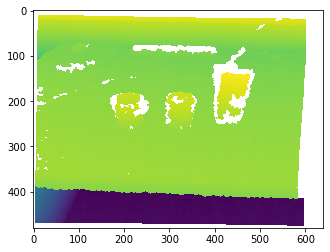

In [60]:
plt.imshow(corrected['z'])

In [61]:
zs_no_nans=np.zeros((corrected['z'].shape))
for i in range(corrected['z'].shape[0]):
    for j in range(corrected['z'].shape[1]):
        if np.isnan(corrected['z'][i,j]):
            zs_no_nans[i,j]=1.0
            #print ('reject')
        else:
            zs_no_nans[i,j]=corrected['z'][i,j]

In [62]:
zs_no_nans

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

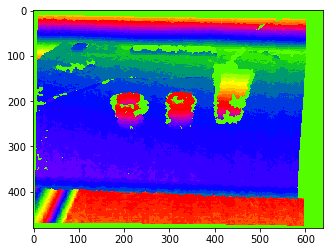

In [63]:
plt.imshow(zs_no_nans, cmap='prism')

In [64]:
zs_no_nans[300,300]

-0.41110527515411377

In [65]:
histogram, bin_edges =(np.histogram(zs_no_nans, bins=50))

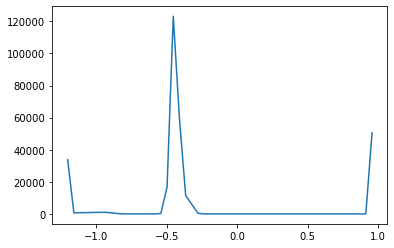

In [66]:
plt.plot(bin_edges[0:-1], histogram)  

In [67]:
histogram[:-1].argmax(), bin_edges[histogram[:-1].argmax()]

(17, -0.45389294862747187)

In [117]:
bin_edges[histogram[:-1].argmax()+1]   ## Most repeated z's sould be a plane (pararlel to floor)
### it is  approx 40cms beneath de sensor ( z=-0.40m)

-0.40983558654785157

In [82]:
t = tfBuffer.lookup_transform('map', 'head_rgbd_sensor_link', rospy.Time())
trans=t.transform.translation.z

In [83]:
img_corrected = np.where((-zs_no_nans < trans*0.99) ,zs_no_nans,5.0)  #FLOOR


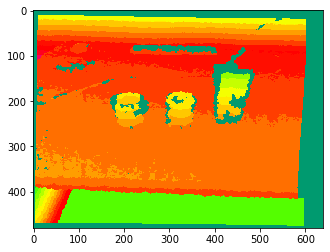

In [84]:
plt.imshow(img_corrected, cmap='prism')

In [85]:
img_corrected[300,30], zs_no_nans[300,30]

(-0.40385475754737854, -0.40385475754737854)

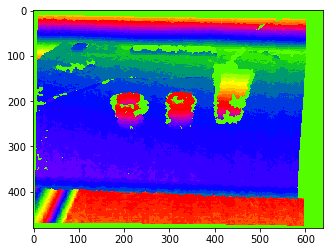

In [86]:
plt.imshow(zs_no_nans, cmap='prism')

In [124]:
plane_height= (trans)+bin_edges[histogram[:-1].argmax()+1]
(trans*0.999)-0.705, (trans*0.999)-plane_height


(0.3972276169344614, 0.4087322555999693)

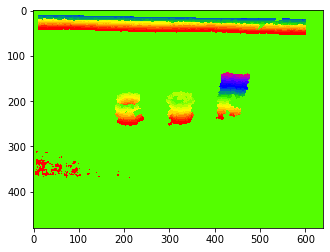

In [125]:
#img_corrected = np.where(    (-zs_no_nans <  (trans*0.999)-0.705  )                         ,zs_no_nans,1)  # ver celda de arriba de donde salio este numero
img_corrected = np.where(    (-zs_no_nans <  (trans*0.999)-plane_height-.01  )                         ,zs_no_nans,1)  # ver celda de arriba de donde salio este numero
plt.imshow(img_corrected, cmap='prism')

In [96]:
img_corrected[100,600],img_corrected[100,300]

(-0.4708558917045593, -0.4534167945384979)

In [97]:
img_corrected[300,300], zs_no_nans[300,300]

(-0.41110527515411377, -0.41110527515411377)

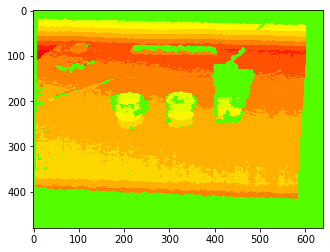

In [98]:
#table1#img_corrected_top = np.where(    (-img_corrected >  (trans*0.999)-0.751  )                        ,img_corrected,1)
img_corrected_top = np.where(    (-img_corrected >  (trans*0.999)-0.77 )                        ,img_corrected,5)

plt.imshow(img_corrected_top, cmap='prism')

In [99]:
img_corrected[300,300], zs_no_nans[300,300]

(-0.41110527515411377, -0.41110527515411377)

In [100]:
(trans*0.999)-0.751

0.35122761693446136

In [101]:
lower=100
higher=200000
reg_ly= 30
reg_hy=600
contours, hierarchy = cv2.findContours(img_corrected.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
i=0
cents=[]
points=[]
images=[]
for i, contour in enumerate(contours):

    area = cv2.contourArea(contour)
    if area > lower and area < higher :
        M = cv2.moments(contour)
        # calculate x,y coordinate of center
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        if (cY > reg_ly and cY < reg_hy  ):

                boundRect = cv2.boundingRect(contour)
                #just for drawing rect, dont waste too much time on this
                #image_aux= iimmg[boundRect[1]:boundRect[1]+max(boundRect[2],boundRect[3]),boundRect[0]:boundRect[0]+max(boundRect[2],boundRect[3])]
                

                image_aux= image[boundRect[1]:boundRect[1]+boundRect[3],boundRect[0]:boundRect[1]+boundRect[2]]
                images.append(image_aux)
                image_aux= img_corrected[boundRect[1]:boundRect[1]+boundRect[3],boundRect[0]:boundRect[0]+boundRect[2]]

                mask=np.where(image_aux!=5)
                npmask=np.asarray(mask).T
                hsv_image=cv2.rectangle(hsv_image,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
                cv2.circle(hsv_image, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(hsv_image, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                print ('cX,cY',cX,cY,'len mask',len(npmask))
                

cX,cY 296 227 len mask 686
cX,cY 316 197 len mask 510
cX,cY 354 207 len mask 588
cX,cY 240 213 len mask 1715
cX,cY 177 202 len mask 945
cX,cY 83 125 len mask 1449
cX,cY 436 170 len mask 16684
cX,cY 314 84 len mask 4114


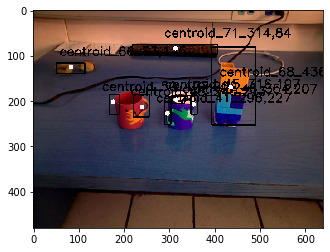

In [102]:
plt.imshow(hsv_image)